In [1]:
import numpy as np
import os

from osgeo import gdal
import matplotlib.pyplot as plt
import pandas as pd
from utils2 import *
from layers import *
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [101]:
raster_data_path = '/home/htang6/Satellite/IGH_104896_allcolor.tif'
raster_dataset = gdal.Open(raster_data_path, gdal.GA_ReadOnly)
geo_transform = raster_dataset.GetGeoTransform()
proj = raster_dataset.GetProjectionRef()
bands_data = []
for b in range(1, raster_dataset.RasterCount+1):
    band = raster_dataset.GetRasterBand(b)
    bands_data.append(band.ReadAsArray())

bands_data = np.dstack(bands_data)
rows, cols, n_bands = bands_data.shape

In [102]:
# bands_data = np.moveaxis(bands_data, -1, 0)
# bands_data = bands_data[[2,0,1]]
# bands_data = bands_data.astype('float')
print bands_data.shape


(10209, 9807, 4)


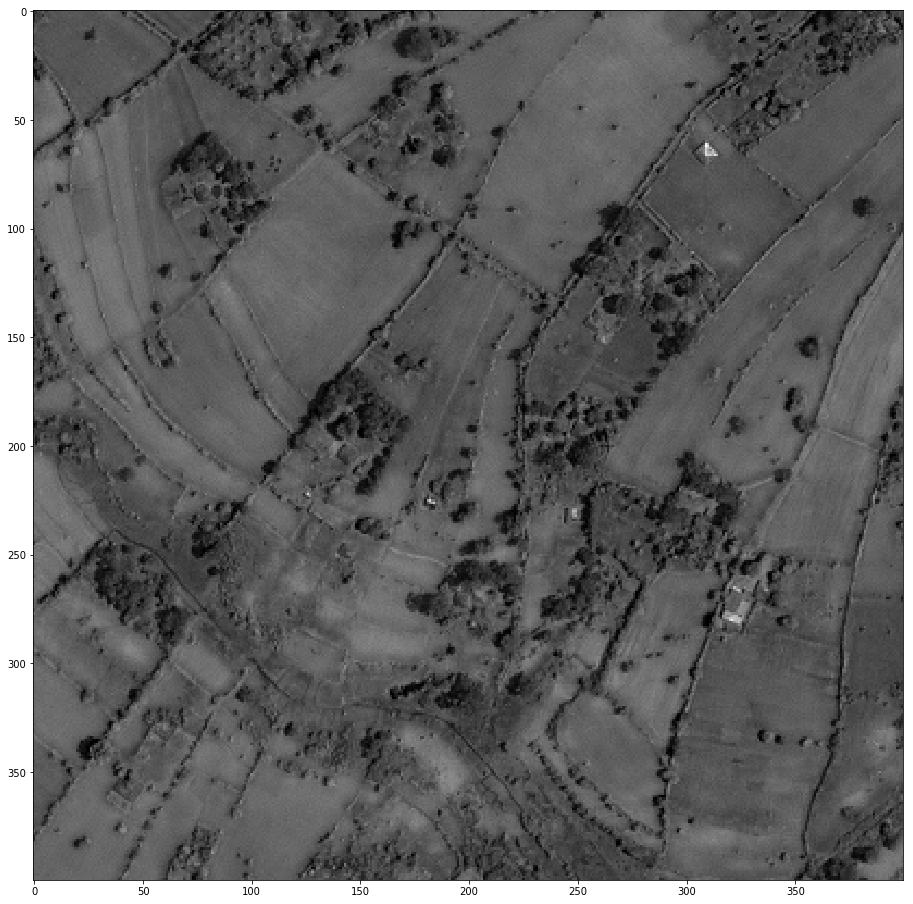

In [129]:
plt.figure(figsize=(16, 16))
# print bands_data[:3, 0:200, 0:200].shape
plt.imshow(bands_data[100:500,100:500, 0], cmap='gray')
plt.show()

In [5]:
data_dir = '/home/htang6/workspace/data/house_detection/bgIMG'
annos_dir = '/home/htang6/workspace/data/house_detection'
bbox_dir = '/home/htang6/workspace/house_detection/results/test/0/bbox/test_400'
bboxes = np.load(os.path.join(bbox_dir, '364_086_img.npy_pbb.npy'))
filenames = os.listdir(data_dir)
annos = pd.read_excel(os.path.join(annos_dir, '364_086.xls'))
d = [15 for _ in xrange(len(annos))]
annos['d'] = d
print annos.as_matrix(columns=['Cell_Y', 'Cell_X', 'd'])

[[  913  1864    15]
 [ 1008  1837    15]
 [ 1064  1868    15]
 ..., 
 [17607  9720    15]
 [17481  9786    15]
 [17506 10043    15]]


In [3]:
img = plt.imread(os.path.join(data_dir, '364_086.jpg'))

/home/htang6/anaconda2/lib/python2.7/site-packages/PIL/Image.py:2438: DecompressionBombWarning: Image size (363724800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


In [6]:
count = 0
for index, row in annos.iterrows():
    y, x, side_len = row['Cell_Y'], row['Cell_X'], row['d']
    ground_truth = [y, x, side_len, side_len]
    for box in bboxes:
        y, x = box[1], box[2]
        if y >= ground_truth[0] - side_len / 2 and y <= ground_truth[0] + side_len / 2 and x >= ground_truth[1] - side_len / 2 and x <= ground_truth[1] + side_len / 2:
            count += 1
            break
            
print 'Accuracy: ', float(count) / len(annos)

Accuracy:  0.491638795987


(1374, 5)


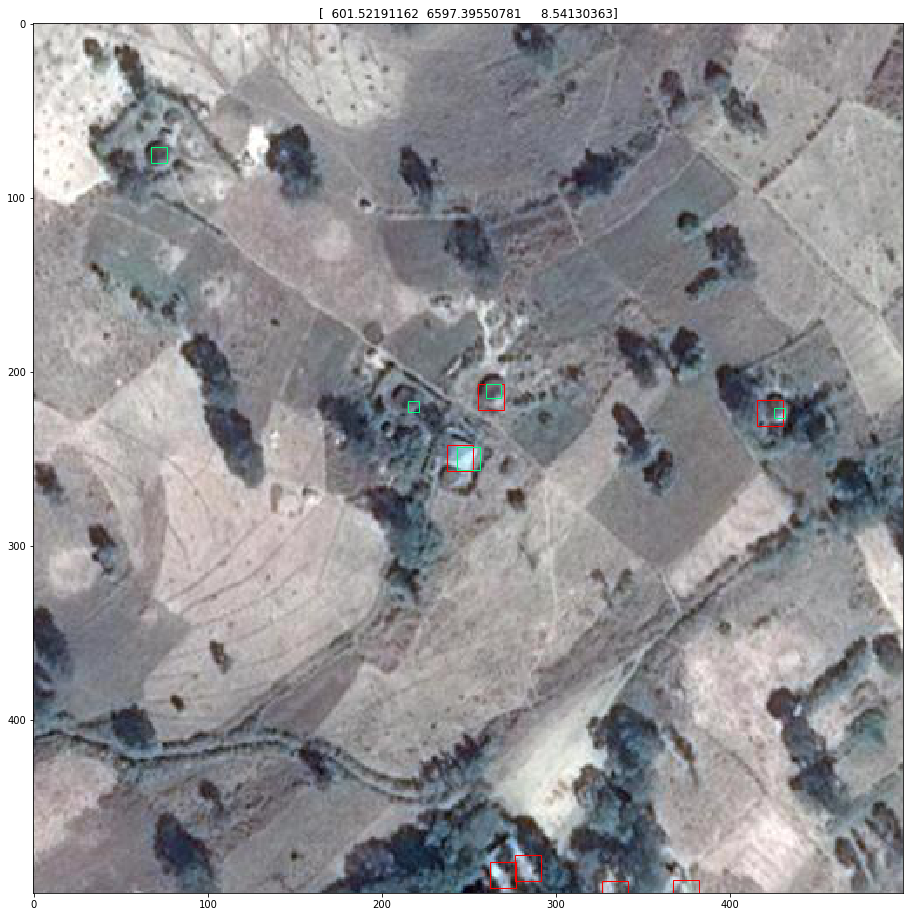

In [7]:
print bboxes.shape
voxelWidth = 500

## 200 missed a lot
target = bboxes[15][1:4]

def npy2df(array):
    return pd.DataFrame(array[:, 1:4], columns=['Cell_Y', 'Cell_X', 'd'], dtype=np.float32)
    
# targets = npy2df(bboxes)
# print targets
# targets = targets.query('Cell_X >= @target[1] - @voxelWidth / 2 & Cell_X <= @target[1] + @voxelWidth / 2 & Cell_Y >= @target[0] - @voxelWidth / 2 & Cell_Y <= @target[0] + @voxelWidth / 2')
# targets.as_matrix(columns=['Cell_Y', 'Cell_X', 'd'])
# indics = np.where(np.logical_and(bboxes[:,1] > target[0] - voxelWidth / 2, bboxes[:,1] < target[0] + voxelWidth / 2, 
#                              bboxes[:,2] > target[1] - voxelWidth / 2, bboxes[:,2] < target[1] + voxelWidth / 2))

showTargetImgComp(img, target, plt, targets=bboxes[:,1:4], annos=annos.as_matrix(columns=['Cell_Y', 'Cell_X', 'd']), d=target[-1], voxelWidth=voxelWidth)

In [65]:
annos[annos['OBJECTID'] == 1]

,OBJECTID,Latitude,Longitude,Cell_X,Cell_Y,d
0,1,8.695656,36.40908,1864,913,24


      OBJECTID  Latitude  Longitude  Cell_X  Cell_Y   d
0            1  8.695656  36.409080    1864     913  13
1            2  8.695156  36.408931    1837    1008  14
2            3  8.694858  36.409098    1868    1064  13
3            4  8.694603  36.408836    1819    1112   6
4            5  8.694674  36.408657    1786    1098  13
5            6  8.694710  36.408211    1702    1092  10
6            7  8.694507  36.408776    1808    1130   9
7            8  8.694442  36.408860    1823    1142  11
8            9  8.694281  36.408753    1803    1172   6
9           10  8.694067  36.408396    1737    1213  13
10          11  8.694252  36.408526    1761    1178   7
11          12  8.694264  36.419228    3756    1176  12
12          13  8.692949  36.417545    3442    1424   5
13          14  8.692699  36.417729    3477    1471   5
14          15  8.692741  36.417521    3438    1463  11
15          16  8.692860  36.417515    3437    1440  10
16          17  8.692860  36.417366    3409    1

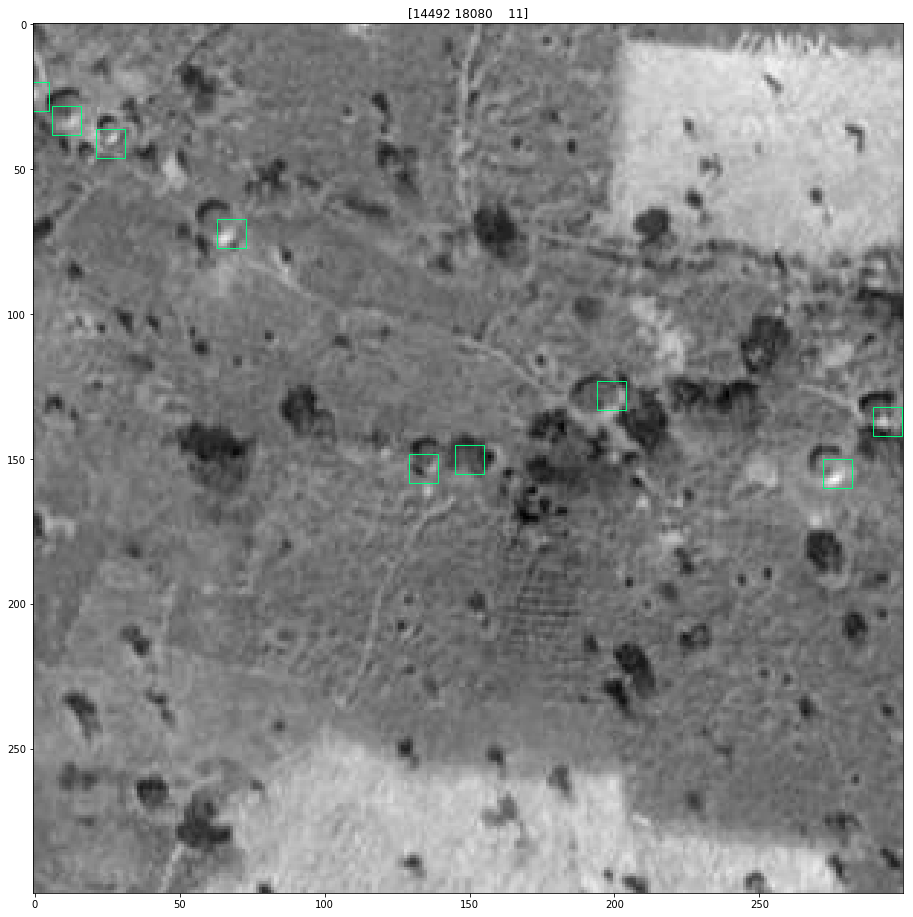

In [27]:
id = 1000
voxelWidth = 300
target = [annos[annos['OBJECTID'] == id]['Cell_Y'].item(), annos[annos['OBJECTID'] == id]['Cell_X'].item(), 10]
target = np.array(target)
targets = annos.query('Cell_X >= @target[1] - @voxelWidth / 2 & Cell_X <= @target[1] + @voxelWidth / 2 & Cell_Y >= @target[0] - @voxelWidth / 2 & Cell_Y <= @target[0] + @voxelWidth / 2')

targets = targets.as_matrix(columns=['Cell_Y', 'Cell_X', 'd'])

# print target
# print targets
showTargetImgComp(np.moveaxis(img, -1, 0), target, plt, targets=targets, d=target[-1], voxelWidth=voxelWidth)

In [227]:
np.genfromtxt(os.path.join(annos_dir, 'filenames.txt'), dtype=str)

array(['363_086', '364_085', '364_086', '364_087'],
      dtype='|S7')

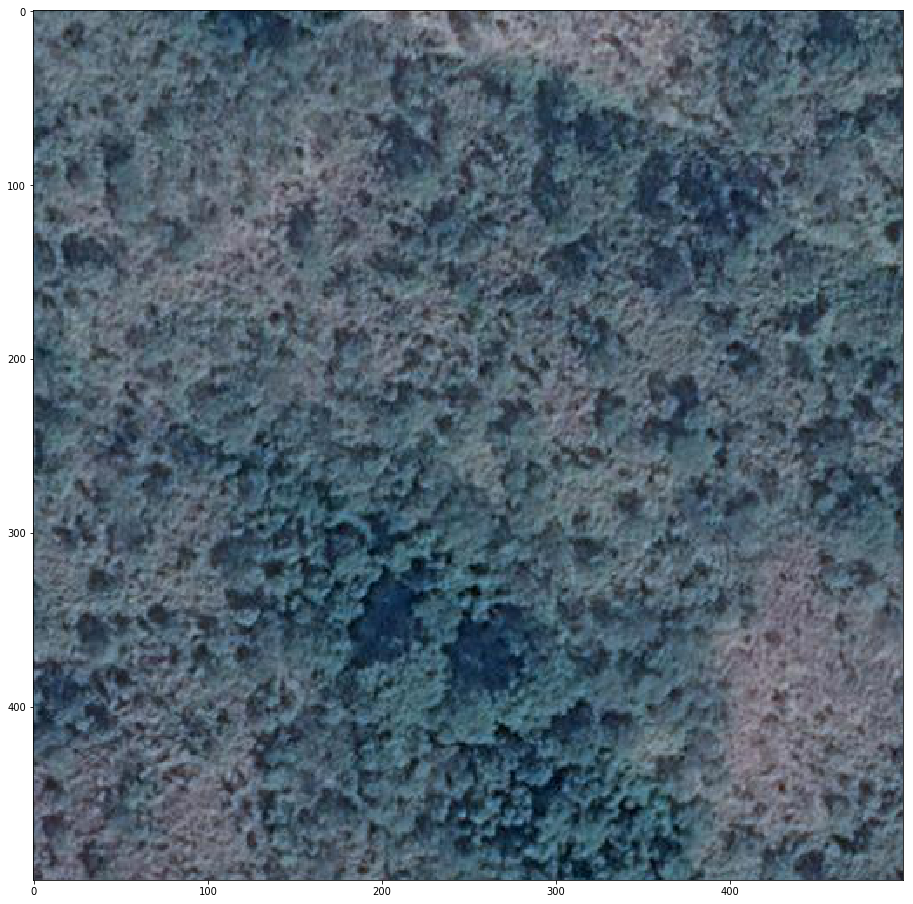

In [246]:
plt.imshow(img[10000:10500, 10000:10500, :])